In [1]:
# Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
# Step 2: Configure Device and Define Labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Step 3: Data Preprocessing and Load CIFAR-10 Dataset with ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

Using device: cuda


In [3]:
# Load CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


In [4]:
# Subset dataset for quicker training (optional)
dataset = Subset(dataset, range(500))  # Use first 500 samples

In [5]:
# Split dataset into train and validation sets (80/20)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [7]:
# Step 4: Define Training and Evaluation Function (supports GoogLeNet aux outputs)
def train_and_evaluate(model, name, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Special handling for GoogLeNet auxiliary outputs
            if name.lower() == "googlenet" and model.aux_logits:
                outputs = model(inputs)
                # The output from GoogLeNet with aux_logits=True is a tuple
                # The first element is the main output, the rest are auxiliary outputs
                if isinstance(outputs, tuple):
                    main_outputs = outputs[0]
                    aux_outputs = outputs[1:] # Get all auxiliary outputs
                    loss1 = criterion(main_outputs, labels)
                    loss = loss1 # Start with main loss
                    # Add loss from each auxiliary output
                    for aux_output in aux_outputs:
                         loss += 0.4 * criterion(aux_output, labels)
                    outputs = main_outputs # Use main outputs for prediction
                else: # If it's not a tuple, it must be the main output
                    loss = criterion(outputs, labels)

            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        train_accs.append(100 * correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        val_accs.append(100 * correct / total)

        print(f"{name} Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.2f}%, Val Acc: {val_accs[-1]:.2f}%")

    return model, train_accs, val_accs


In [8]:
# Step 5: Load pretrained models and modify final layers
def get_model(name):
    if name == "vgg":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, 10)
    elif name == "resnet":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif name == "googlenet":
        model = models.googlenet(pretrained=True, aux_logits=True)
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        raise ValueError("Unknown model name")
    return model

In [10]:
# Step 6: Train all models and store results
results = {}
trained_models = {}

for model_name in ["vgg", "resnet", "googlenet"]:
    print(f"\n🔹 Training {model_name.upper()} on CIFAR-10...")
    model = get_model(model_name)
    trained_model, train_acc, val_acc = train_and_evaluate(model, model_name, num_epochs=10)
    results[model_name] = (train_acc, val_acc)
    trained_models[model_name] = trained_model



🔹 Training VGG on CIFAR-10...
vgg Epoch 1/10 - Train Acc: 21.75%, Val Acc: 48.00%
vgg Epoch 2/10 - Train Acc: 57.75%, Val Acc: 57.00%
vgg Epoch 3/10 - Train Acc: 75.75%, Val Acc: 64.00%
vgg Epoch 4/10 - Train Acc: 86.75%, Val Acc: 67.00%
vgg Epoch 5/10 - Train Acc: 94.25%, Val Acc: 69.00%
vgg Epoch 6/10 - Train Acc: 97.25%, Val Acc: 76.00%
vgg Epoch 7/10 - Train Acc: 99.25%, Val Acc: 69.00%
vgg Epoch 8/10 - Train Acc: 99.25%, Val Acc: 77.00%
vgg Epoch 9/10 - Train Acc: 100.00%, Val Acc: 69.00%


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


vgg Epoch 10/10 - Train Acc: 99.50%, Val Acc: 70.00%

🔹 Training RESNET on CIFAR-10...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


resnet Epoch 1/10 - Train Acc: 19.75%, Val Acc: 36.00%
resnet Epoch 2/10 - Train Acc: 91.75%, Val Acc: 48.00%
resnet Epoch 3/10 - Train Acc: 98.25%, Val Acc: 67.00%
resnet Epoch 4/10 - Train Acc: 99.75%, Val Acc: 75.00%
resnet Epoch 5/10 - Train Acc: 100.00%, Val Acc: 74.00%
resnet Epoch 6/10 - Train Acc: 100.00%, Val Acc: 74.00%
resnet Epoch 7/10 - Train Acc: 100.00%, Val Acc: 74.00%
resnet Epoch 8/10 - Train Acc: 100.00%, Val Acc: 76.00%
resnet Epoch 9/10 - Train Acc: 100.00%, Val Acc: 75.00%


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet Epoch 10/10 - Train Acc: 100.00%, Val Acc: 75.00%

🔹 Training GOOGLENET on CIFAR-10...
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 178MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


googlenet Epoch 1/10 - Train Acc: 17.75%, Val Acc: 31.00%
googlenet Epoch 2/10 - Train Acc: 62.25%, Val Acc: 52.00%
googlenet Epoch 3/10 - Train Acc: 81.25%, Val Acc: 54.00%
googlenet Epoch 4/10 - Train Acc: 87.75%, Val Acc: 53.00%
googlenet Epoch 5/10 - Train Acc: 91.25%, Val Acc: 54.00%
googlenet Epoch 6/10 - Train Acc: 93.25%, Val Acc: 61.00%
googlenet Epoch 7/10 - Train Acc: 96.25%, Val Acc: 64.00%
googlenet Epoch 8/10 - Train Acc: 97.75%, Val Acc: 68.00%
googlenet Epoch 9/10 - Train Acc: 98.25%, Val Acc: 69.00%
googlenet Epoch 10/10 - Train Acc: 98.00%, Val Acc: 71.00%


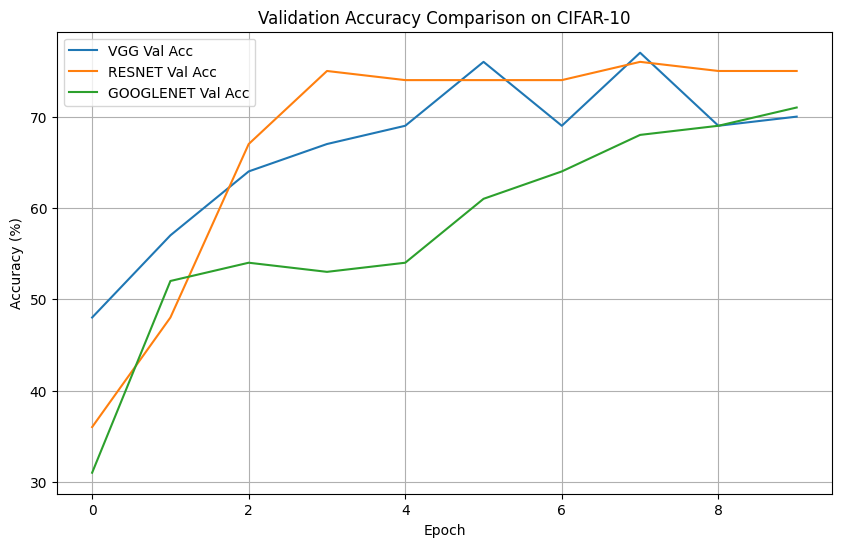

In [11]:
# Step 7: Plot Validation Accuracy Comparison
plt.figure(figsize=(10, 6))
for name, (train_acc, val_acc) in results.items():
    plt.plot(val_acc, label=f'{name.upper()} Val Acc')
plt.title('Validation Accuracy Comparison on CIFAR-10')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Step 8: Predict on Custom Image
def predict_image(image_path, models_dict):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    print(f"\n🖼 Prediction results for image: {image_path}")
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            outputs = model(image)
            # Handle GoogLeNet output during prediction
            if model_name.lower() == "googlenet" and isinstance(outputs, tuple):
                outputs = outputs[0] # Use main output for prediction
            _, predicted = outputs.max(1)
            pred_class = class_names[predicted.item()]
            print(f"{model_name.upper():<10} => {pred_class}")

custom_image_path = "dog1.jpeg"
if os.path.exists(custom_image_path):
    predict_image(custom_image_path, trained_models)
else:
    print(f"\n❗ Image not found: {custom_image_path}. Please add an image to test.")


🖼 Prediction results for image: dog1.jpeg
VGG        => dog
RESNET     => dog
GOOGLENET  => dog
